# Handwritten Digits Recognition Using Shallow Neural Network

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Training data comes from the "MNIST" data set, you can download it from [Kaggle](https://www.kaggle.com/c/digit-recognizer/data).

## Section 1, Data Preparation

In [2]:
data = np.genfromtxt("train.csv", delimiter=',', skip_header=1)
print(data.shape)

(42000, 785)


In [3]:
np.random.shuffle(data)
print(data.shape)
print(data[:10, 0])

(42000, 785)
[2. 7. 7. 9. 4. 5. 7. 2. 7. 2.]


In [4]:
features = data[:, 1:].T
labels = data[:, 0]
labels = np.reshape(labels, (1, -1))
print(features.shape)
print(labels.shape)

(784, 42000)
(1, 42000)


In [5]:
m = features.shape[1]
nx = features.shape[0]
ny = 10

In [6]:
def labels_to_Y(labels):
    Y = np.zeros((ny, m))
    for i in range(m):
        Y[int(labels[0, i]), i] = 1
    return Y

def Y_to_labels(Y):
    labels = np.argmax(Y, axis=0).astype(float)
    labels = np.reshape(labels, (1, -1))
    return labels

def X_to_images(X):
    images = [np.reshape(X[:, i], (28, 28)) for i in range(X.shape[1])]
    return images

(10, 42000)
2.0
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


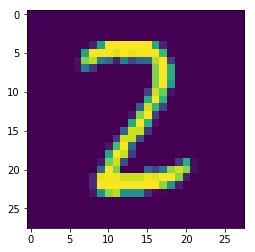

In [7]:
X = features / 255
Y = labels_to_Y(labels)
images = X_to_images(X)
print(Y.shape)
plt.imshow(images[0])
print(labels[0, 0])
print(Y[:, 0])

In [8]:
train_ratio = 0.9

In [9]:
test_ratio = 1 - train_ratio
train_m = int(m * train_ratio)
test_m = m - train_m
train_X = X[:, :train_m]
test_X = X[:, train_m:]
train_Y = Y[:, :train_m]
test_Y = Y[:, train_m:]
train_labels = Y_to_labels(train_Y)
test_labels = Y_to_labels(test_Y)
print(train_X.shape)
print(train_Y.shape)
print(test_X.shape)
print(test_Y.shape)
print(train_labels.shape)

(784, 37800)
(10, 37800)
(784, 4200)
(10, 4200)
(1, 37800)


## Section 2, Design Neural Network

In [10]:
def sigmoid(z):
    a = 1/ (1 + np.exp(-z))
    return a

def sigmoid_prime(z):
    p1 = np.exp(-z)
    a = p1/((1+p1)**2)
    return a

def relu(z):
    a = np.maximum(z, 0.01*z)
    return a

def relu_prime(z):
    a = np.where(z > 0, 1, 0.01)
    return a

def tanh(z):
    p1 = np.exp(z)
    p2 = np.exp(-z)
    a = (p1-p2)/(p1+p2)
    return a
    
def tanh_prime(z):
    p1 = tanh(z)
    a = 1-p1**2
    return a

def softmax(z):
    t = np.exp(z)
    n = np.sum(t, axis = 0)
    a = t/n
    return a

In [11]:
def loss_function_for__config_multi_layer_classifier_without_regularization(Y_hat, Y):
    delta = 1e-10
    l = np.sum(-Y*np.log(Y_hat+delta), axis=0)
    return l

def forward_propagation_for_config_multi_layer_classifier_without_regularization(model):
    X = model['X']
    Y = model['Y']
    n = model['n']
    L = model['L']
    f = model['f']
    W = model['W']
    b = model['b']
    Z = model['Z']
    A = model['A']
    costs = model['costs']
    loss_function = model['loss_function']
    A[0] = X
    for i in range(1, L+1):
        Z[i] = np.matmul(W[i], A[i-1]) + b[i]
        A[i] = f[i](Z[i])
    costs.append(np.sum(loss_function(A[L], Y)))

def back_propagation_for_config_multi_layer_classifier_without_regularization(model):
    n = model['n']
    L = model['L']
    f_prime = model['f_prime']
    m = model['m']
    W = model['W']
    Z = model['Z']
    A = model['A']
    Y = model['Y']
    dW = model['dW']
    db = model['db']
    dA = model['dA']
    dZ = model['dZ']
    dZ[L] = A[L] - Y
    dW[L] = np.matmul(dZ[L], A[L-1].T)/m
    db[L] = np.sum(dZ[L], axis=1, keepdims=True)/m
    for i in reversed(range(1, L)):
        dZ[i] = np.matmul(W[i+1].T, dZ[i+1]) * f_prime[i](Z[i])
        dW[i] = np.matmul(dZ[i], A[i-1].T)/m
        db[i] = np.sum(dZ[i], axis=1, keepdims=True)/m
        
def update_for_config_multi_layer_classifier_without_regularization(model):
    L = model['L']
    W = model['W']
    b = model['b']
    dW = model['dW']
    db = model['db']
    learning_rate = model['learning_rate']
    for i in range(1, L+1):
        W[i] -= learning_rate*dW[i]
        b[i] -= learning_rate*db[i]
    
    
def predict_for_config_multi_layer_classifier_without_regularization(model, test_X):
    L = model['L']
    A = model['A']
    Z = model['Z']
    W = model['W']
    b = model['b']
    f = model['f']
    A[0] = test_X
    for i in range(1, L+1):
        Z[i] = np.matmul(W[i], A[i-1]) + b[i]
        A[i] = f[i](Z[i])
    return A[L]
    
    
def config_multi_layer_classifier_without_regularization(X, Y, neuron_of_hidden_layer, learning_rate):
    n_input_layer = X.shape[0]
    n_output_layer = Y.shape[0]
    
    m = X.shape[1]
    n = [n_input_layer] + neuron_of_hidden_layer + [n_output_layer]
    L = len(n)-1
    f = [tanh if i != 0 else None for i in range(L)]
    f.append(softmax)
    f_prime = [tanh_prime if i != 0 else None for i in range(L)]
    f_prime.append(None)
    W = [np.random.normal(0, 1, (n[i], n[i-1])) if i != 0 else None for i in range(L+1)]
    b = [np.random.normal(0, 1, (n[i], 1)) if i != 0 else None for i in range(L+1)]
    Z = [None for i in range(L+1)]
    A = [None for i in range(L+1)]
    dW = [None for i in range(L+1)]
    db = [None for i in range(L+1)]
    dA = [None for i in range(L+1)]
    dZ = [None for i in range(L+1)]
    costs = []
    
    model = dict()
    model['X'] = X
    model['Y'] = Y
    model['m'] = m
    model['n'] = n
    model['L'] = L
    model['f'] = f
    model['f_prime'] = f_prime
    model['W'] = W
    model['b'] = b
    model['Z'] = Z
    model['A'] = A
    model['dW'] = dW
    model['db'] = db
    model['dA'] = dA
    model['dZ'] = dZ
    model['loss_function'] = loss_function_for__config_multi_layer_classifier_without_regularization
    model['costs'] = costs
    model['learning_rate'] = learning_rate
    model['forwardprop'] = forward_propagation_for_config_multi_layer_classifier_without_regularization
    model['backprop'] = back_propagation_for_config_multi_layer_classifier_without_regularization
    model['update'] = update_for_config_multi_layer_classifier_without_regularization
    model['predict'] = predict_for_config_multi_layer_classifier_without_regularization
    
    return model
        
    

In [12]:
def loss_function_for__config_multi_layer_classifier_with_regularization(model, Y_hat):
    n = model['n']
    Y = model['Y']
    W = model['W']
    L = model['L']
    m = model['m']
    penalty = model['penalty']
    
    delta = 1e-10
    l = np.sum(-Y*np.log(Y_hat+delta), axis=0)
    p = 0
    for i in range(1, L+1):
        p = p + np.sum(W[i]**2)*penalty/(2*m)
    l = l + p
    return l

def forward_propagation_for_config_multi_layer_classifier_with_regularization(model):
    X = model['X']
    Y = model['Y']
    n = model['n']
    L = model['L']
    f = model['f']
    W = model['W']
    b = model['b']
    Z = model['Z']
    A = model['A']
    costs = model['costs']
    loss_function = model['loss_function']
    A[0] = X
    for i in range(1, L+1):
        Z[i] = np.matmul(W[i], A[i-1]) + b[i]
        A[i] = f[i](Z[i])
    costs.append(np.sum(loss_function(model, A[L])))

def back_propagation_for_config_multi_layer_classifier_with_regularization(model):
    n = model['n']
    L = model['L']
    f_prime = model['f_prime']
    m = model['m']
    W = model['W']
    Z = model['Z']
    A = model['A']
    Y = model['Y']
    penalty = model['penalty']
    dW = model['dW']
    db = model['db']
    dA = model['dA']
    dZ = model['dZ']
    dZ[L] = A[L] - Y
    dW[L] = np.matmul(dZ[L], A[L-1].T)/m
    db[L] = np.sum(dZ[L], axis=1, keepdims=True)/m
    for i in reversed(range(1, L)):
        dZ[i] = np.matmul(W[i+1].T, dZ[i+1]) * f_prime[i](Z[i])
        dW[i] = np.matmul(dZ[i], A[i-1].T)/m + W[i]*penalty/m
        db[i] = np.sum(dZ[i], axis=1, keepdims=True)/m
        
def update_for_config_multi_layer_classifier_with_regularization(model):
    L = model['L']
    W = model['W']
    b = model['b']
    dW = model['dW']
    db = model['db']
    learning_rate = model['learning_rate']
    for i in range(1, L+1):
        W[i] -= learning_rate*dW[i]
        b[i] -= learning_rate*db[i]
    
    
def predict_for_config_multi_layer_classifier_with_regularization(model, test_X):
    L = model['L']
    A = model['A']
    Z = model['Z']
    W = model['W']
    b = model['b']
    f = model['f']
    A[0] = test_X
    for i in range(1, L+1):
        Z[i] = np.matmul(W[i], A[i-1]) + b[i]
        A[i] = f[i](Z[i])
    return A[L]
    
    
def config_multi_layer_classifier_with_regularization(X, Y, neuron_of_hidden_layer, learning_rate, penalty):
    n_input_layer = X.shape[0]
    n_output_layer = Y.shape[0]
    
    m = X.shape[1]
    n = [n_input_layer] + neuron_of_hidden_layer + [n_output_layer]
    L = len(n)-1
    f = [tanh if i != 0 else None for i in range(L)]
    f.append(softmax)
    f_prime = [tanh_prime if i != 0 else None for i in range(L)]
    f_prime.append(None)
    W = [np.random.normal(0, 1, (n[i], n[i-1])) if i != 0 else None for i in range(L+1)]
    b = [np.random.normal(0, 1, (n[i], 1)) if i != 0 else None for i in range(L+1)]
    Z = [None for i in range(L+1)]
    A = [None for i in range(L+1)]
    dW = [None for i in range(L+1)]
    db = [None for i in range(L+1)]
    dA = [None for i in range(L+1)]
    dZ = [None for i in range(L+1)]
    costs = []
    
    model = dict()
    model['X'] = X
    model['Y'] = Y
    model['m'] = m
    model['n'] = n
    model['L'] = L
    model['f'] = f
    model['f_prime'] = f_prime
    model['W'] = W
    model['b'] = b
    model['Z'] = Z
    model['A'] = A
    model['dW'] = dW
    model['db'] = db
    model['dA'] = dA
    model['dZ'] = dZ
    model['loss_function'] = loss_function_for__config_multi_layer_classifier_with_regularization
    model['costs'] = costs
    model['learning_rate'] = learning_rate
    model['penalty'] = penalty
    model['forwardprop'] = forward_propagation_for_config_multi_layer_classifier_with_regularization
    model['backprop'] = back_propagation_for_config_multi_layer_classifier_with_regularization
    model['update'] = update_for_config_multi_layer_classifier_with_regularization
    model['predict'] = predict_for_config_multi_layer_classifier_with_regularization
    
    return model
        
    

In [13]:
def train_model(iteration_times, model):
    forwardprop = model['forwardprop']
    backprop = model['backprop']
    update = model['update']
    costs = model['costs']
    for i in range(iteration_times):
        forwardprop(model)
        backprop(model)
        update(model)
        print("iteration %d, current loss: %f" % (i, costs[len(costs)-1]))
        

In [16]:
model = config_multi_layer_classifier_with_regularization(train_X, train_Y, [28, 28, 28, 28], 1, 1)

iteration 0, current loss: 78715.264597
iteration 1, current loss: 78236.464794
iteration 2, current loss: 77600.507393
iteration 3, current loss: 77057.673517
iteration 4, current loss: 76360.385192
iteration 5, current loss: 75914.287180
iteration 6, current loss: 75421.685645
iteration 7, current loss: 75084.391366
iteration 8, current loss: 74559.457360
iteration 9, current loss: 74039.086338
iteration 10, current loss: 73493.296201
iteration 11, current loss: 72970.476781
iteration 12, current loss: 72609.322378
iteration 13, current loss: 72172.417691
iteration 14, current loss: 71950.954370
iteration 15, current loss: 71562.467286
iteration 16, current loss: 71446.261086
iteration 17, current loss: 71150.341077
iteration 18, current loss: 71167.083730
iteration 19, current loss: 70698.907756
iteration 20, current loss: 70551.464949
iteration 21, current loss: 70103.605797
iteration 22, current loss: 70023.459772
iteration 23, current loss: 69532.539083
iteration 24, current loss

iteration 198, current loss: 49399.237469
iteration 199, current loss: 49487.436954
iteration 200, current loss: 49284.147189
iteration 201, current loss: 49399.958856
iteration 202, current loss: 49206.000478
iteration 203, current loss: 49328.718602
iteration 204, current loss: 49151.348685
iteration 205, current loss: 49292.173416
iteration 206, current loss: 49161.671335
iteration 207, current loss: 49271.662100
iteration 208, current loss: 49012.204830
iteration 209, current loss: 49049.919809
iteration 210, current loss: 48887.654391
iteration 211, current loss: 48964.406838
iteration 212, current loss: 48735.377581
iteration 213, current loss: 48787.756244
iteration 214, current loss: 48615.230958
iteration 215, current loss: 48682.398640
iteration 216, current loss: 48490.410645
iteration 217, current loss: 48584.261525
iteration 218, current loss: 48413.685060
iteration 219, current loss: 48572.574420
iteration 220, current loss: 48392.268686
iteration 221, current loss: 48631

iteration 394, current loss: 41725.399631
iteration 395, current loss: 41668.443072
iteration 396, current loss: 41681.756945
iteration 397, current loss: 41657.806538
iteration 398, current loss: 41684.522470
iteration 399, current loss: 41708.890131
iteration 400, current loss: 41654.967927
iteration 401, current loss: 41656.788237
iteration 402, current loss: 41551.380648
iteration 403, current loss: 41507.798751
iteration 404, current loss: 41421.370596
iteration 405, current loss: 41329.062498
iteration 406, current loss: 41270.357943
iteration 407, current loss: 41172.009107
iteration 408, current loss: 41124.949192
iteration 409, current loss: 41060.168547
iteration 410, current loss: 41028.984727
iteration 411, current loss: 40987.769215
iteration 412, current loss: 40962.241632
iteration 413, current loss: 40941.790337
iteration 414, current loss: 40935.094964
iteration 415, current loss: 40932.390612
iteration 416, current loss: 40973.273802
iteration 417, current loss: 40988

iteration 590, current loss: 37316.495480
iteration 591, current loss: 37395.373425
iteration 592, current loss: 37279.644304
iteration 593, current loss: 37297.757294
iteration 594, current loss: 37321.181391
iteration 595, current loss: 37333.637891
iteration 596, current loss: 37381.960510
iteration 597, current loss: 37305.535782
iteration 598, current loss: 37373.252965
iteration 599, current loss: 37220.495023
iteration 600, current loss: 37269.698839
iteration 601, current loss: 37131.698725
iteration 602, current loss: 37153.308075
iteration 603, current loss: 37028.312160
iteration 604, current loss: 37013.385130
iteration 605, current loss: 36910.465077
iteration 606, current loss: 36884.332916
iteration 607, current loss: 36787.646248
iteration 608, current loss: 36770.337655
iteration 609, current loss: 36666.444747
iteration 610, current loss: 36647.776258
iteration 611, current loss: 36570.599604
iteration 612, current loss: 36558.081448
iteration 613, current loss: 36502

iteration 786, current loss: 34353.400700
iteration 787, current loss: 34328.478420
iteration 788, current loss: 34334.851530
iteration 789, current loss: 34308.535862
iteration 790, current loss: 34329.305627
iteration 791, current loss: 34269.369133
iteration 792, current loss: 34274.169383
iteration 793, current loss: 34232.972529
iteration 794, current loss: 34230.820212
iteration 795, current loss: 34188.069257
iteration 796, current loss: 34172.308438
iteration 797, current loss: 34128.394620
iteration 798, current loss: 34096.975641
iteration 799, current loss: 34062.491029
iteration 800, current loss: 34032.914336
iteration 801, current loss: 34010.067945
iteration 802, current loss: 33999.846608
iteration 803, current loss: 34010.722871
iteration 804, current loss: 34044.776097
iteration 805, current loss: 34108.670146
iteration 806, current loss: 34150.584263
iteration 807, current loss: 34241.039905
iteration 808, current loss: 34239.747604
iteration 809, current loss: 34354

iteration 982, current loss: 32249.445734
iteration 983, current loss: 32214.608598
iteration 984, current loss: 32294.089066
iteration 985, current loss: 32252.852005
iteration 986, current loss: 32332.900286
iteration 987, current loss: 32277.568153
iteration 988, current loss: 32331.998828
iteration 989, current loss: 32257.414042
iteration 990, current loss: 32292.487709
iteration 991, current loss: 32211.317739
iteration 992, current loss: 32258.535065
iteration 993, current loss: 32178.690579
iteration 994, current loss: 32216.294668
iteration 995, current loss: 32153.603953
iteration 996, current loss: 32172.753964
iteration 997, current loss: 32117.179673
iteration 998, current loss: 32126.954202
iteration 999, current loss: 32086.191007
iteration 1000, current loss: 32113.701048
iteration 1001, current loss: 32112.350974
iteration 1002, current loss: 32186.405372
iteration 1003, current loss: 32203.186555
iteration 1004, current loss: 32287.987824
iteration 1005, current loss:

iteration 1173, current loss: 31199.793952
iteration 1174, current loss: 31092.861902
iteration 1175, current loss: 31019.936073
iteration 1176, current loss: 30942.598509
iteration 1177, current loss: 30855.653125
iteration 1178, current loss: 30760.644100
iteration 1179, current loss: 30704.232362
iteration 1180, current loss: 30639.753752
iteration 1181, current loss: 30607.572641
iteration 1182, current loss: 30582.949012
iteration 1183, current loss: 30577.559236
iteration 1184, current loss: 30572.582424
iteration 1185, current loss: 30594.601160
iteration 1186, current loss: 30597.522015
iteration 1187, current loss: 30634.611068
iteration 1188, current loss: 30652.088766
iteration 1189, current loss: 30700.663083
iteration 1190, current loss: 30736.813386
iteration 1191, current loss: 30781.309591
iteration 1192, current loss: 30827.386709
iteration 1193, current loss: 30862.432540
iteration 1194, current loss: 30901.892442
iteration 1195, current loss: 30925.958864
iteration 1

iteration 1364, current loss: 29594.256124
iteration 1365, current loss: 29635.570314
iteration 1366, current loss: 29634.351445
iteration 1367, current loss: 29669.082674
iteration 1368, current loss: 29654.037763
iteration 1369, current loss: 29659.811624
iteration 1370, current loss: 29644.071419
iteration 1371, current loss: 29628.351204
iteration 1372, current loss: 29614.245140
iteration 1373, current loss: 29599.299503
iteration 1374, current loss: 29592.453530
iteration 1375, current loss: 29601.457128
iteration 1376, current loss: 29609.218648
iteration 1377, current loss: 29653.380384
iteration 1378, current loss: 29691.802604
iteration 1379, current loss: 29795.780244
iteration 1380, current loss: 29872.014959
iteration 1381, current loss: 30058.225484
iteration 1382, current loss: 30119.725505
iteration 1383, current loss: 30289.760002
iteration 1384, current loss: 30209.134249
iteration 1385, current loss: 30305.116833
iteration 1386, current loss: 30130.247083
iteration 1

iteration 1555, current loss: 28622.025154
iteration 1556, current loss: 28553.429089
iteration 1557, current loss: 28544.744331
iteration 1558, current loss: 28484.335279
iteration 1559, current loss: 28499.770003
iteration 1560, current loss: 28459.516982
iteration 1561, current loss: 28479.535687
iteration 1562, current loss: 28464.400085
iteration 1563, current loss: 28489.171230
iteration 1564, current loss: 28483.768513
iteration 1565, current loss: 28444.377205
iteration 1566, current loss: 28460.610315
iteration 1567, current loss: 28397.014251
iteration 1568, current loss: 28407.239838
iteration 1569, current loss: 28340.312237
iteration 1570, current loss: 28334.955845
iteration 1571, current loss: 28288.788192
iteration 1572, current loss: 28278.499880
iteration 1573, current loss: 28240.153022
iteration 1574, current loss: 28227.843238
iteration 1575, current loss: 28218.448954
iteration 1576, current loss: 28228.664970
iteration 1577, current loss: 28218.518907
iteration 1

iteration 1746, current loss: 27510.890402
iteration 1747, current loss: 27464.807553
iteration 1748, current loss: 27391.024601
iteration 1749, current loss: 27340.664548
iteration 1750, current loss: 27325.193347
iteration 1751, current loss: 27297.257137
iteration 1752, current loss: 27320.329589
iteration 1753, current loss: 27307.201461
iteration 1754, current loss: 27342.001241
iteration 1755, current loss: 27331.926386
iteration 1756, current loss: 27358.381455
iteration 1757, current loss: 27346.099627
iteration 1758, current loss: 27357.983286
iteration 1759, current loss: 27349.090951
iteration 1760, current loss: 27349.006640
iteration 1761, current loss: 27350.115740
iteration 1762, current loss: 27345.326124
iteration 1763, current loss: 27364.358795
iteration 1764, current loss: 27372.776889
iteration 1765, current loss: 27422.058713
iteration 1766, current loss: 27489.717164
iteration 1767, current loss: 27583.468686
iteration 1768, current loss: 27751.360481
iteration 1

iteration 1937, current loss: 26714.556166
iteration 1938, current loss: 26714.642264
iteration 1939, current loss: 26709.850399
iteration 1940, current loss: 26719.812732
iteration 1941, current loss: 26734.210565
iteration 1942, current loss: 26752.927133
iteration 1943, current loss: 26784.841860
iteration 1944, current loss: 26808.591880
iteration 1945, current loss: 26854.791291
iteration 1946, current loss: 26879.412346
iteration 1947, current loss: 26945.523049
iteration 1948, current loss: 26979.354526
iteration 1949, current loss: 27055.850704
iteration 1950, current loss: 27079.207900
iteration 1951, current loss: 27139.553542
iteration 1952, current loss: 27128.571119
iteration 1953, current loss: 27190.563888
iteration 1954, current loss: 27131.450902
iteration 1955, current loss: 27195.945020
iteration 1956, current loss: 27091.917934
iteration 1957, current loss: 27150.601518
iteration 1958, current loss: 27047.637739
iteration 1959, current loss: 27105.544381
iteration 1

iteration 2128, current loss: 26054.415147
iteration 2129, current loss: 26124.738625
iteration 2130, current loss: 26030.610478
iteration 2131, current loss: 26103.535656
iteration 2132, current loss: 26013.350933
iteration 2133, current loss: 26090.493318
iteration 2134, current loss: 26016.515924
iteration 2135, current loss: 26117.923439
iteration 2136, current loss: 26096.837912
iteration 2137, current loss: 26250.474204
iteration 2138, current loss: 26277.103266
iteration 2139, current loss: 26406.613255
iteration 2140, current loss: 26414.086915
iteration 2141, current loss: 26552.928094
iteration 2142, current loss: 26485.005353
iteration 2143, current loss: 26630.123201
iteration 2144, current loss: 26533.708370
iteration 2145, current loss: 26678.486167
iteration 2146, current loss: 26546.874953
iteration 2147, current loss: 26637.092736
iteration 2148, current loss: 26469.233131
iteration 2149, current loss: 26487.528160
iteration 2150, current loss: 26299.413565
iteration 2

iteration 2319, current loss: 25171.892223
iteration 2320, current loss: 25130.695862
iteration 2321, current loss: 25126.075839
iteration 2322, current loss: 25107.364964
iteration 2323, current loss: 25128.619000
iteration 2324, current loss: 25131.664769
iteration 2325, current loss: 25197.684708
iteration 2326, current loss: 25212.421541
iteration 2327, current loss: 25313.147025
iteration 2328, current loss: 25355.603459
iteration 2329, current loss: 25504.825752
iteration 2330, current loss: 25532.446186
iteration 2331, current loss: 25706.254098
iteration 2332, current loss: 25680.765311
iteration 2333, current loss: 25844.919306
iteration 2334, current loss: 25796.068623
iteration 2335, current loss: 25925.665236
iteration 2336, current loss: 25833.131646
iteration 2337, current loss: 25910.700774
iteration 2338, current loss: 25773.454818
iteration 2339, current loss: 25819.754566
iteration 2340, current loss: 25661.642552
iteration 2341, current loss: 25692.244591
iteration 2

iteration 2510, current loss: 24850.728106
iteration 2511, current loss: 24798.722425
iteration 2512, current loss: 24823.222410
iteration 2513, current loss: 24776.479280
iteration 2514, current loss: 24799.386240
iteration 2515, current loss: 24777.043076
iteration 2516, current loss: 24793.198051
iteration 2517, current loss: 24794.795830
iteration 2518, current loss: 24812.868659
iteration 2519, current loss: 24831.247232
iteration 2520, current loss: 24872.480356
iteration 2521, current loss: 24902.727990
iteration 2522, current loss: 24981.694480
iteration 2523, current loss: 24956.459457
iteration 2524, current loss: 25040.435424
iteration 2525, current loss: 24972.468040
iteration 2526, current loss: 25084.549219
iteration 2527, current loss: 24943.455233
iteration 2528, current loss: 25029.647041
iteration 2529, current loss: 24892.523251
iteration 2530, current loss: 24948.028452
iteration 2531, current loss: 24837.960509
iteration 2532, current loss: 24877.194800
iteration 2

iteration 2701, current loss: 24605.268349
iteration 2702, current loss: 24452.168492
iteration 2703, current loss: 24415.242609
iteration 2704, current loss: 24307.845956
iteration 2705, current loss: 24269.165312
iteration 2706, current loss: 24195.295675
iteration 2707, current loss: 24164.957042
iteration 2708, current loss: 24115.251951
iteration 2709, current loss: 24093.436531
iteration 2710, current loss: 24060.449826
iteration 2711, current loss: 24061.806849
iteration 2712, current loss: 24060.573185
iteration 2713, current loss: 24075.673149
iteration 2714, current loss: 24092.591726
iteration 2715, current loss: 24118.527281
iteration 2716, current loss: 24155.979154
iteration 2717, current loss: 24208.847858
iteration 2718, current loss: 24254.133496
iteration 2719, current loss: 24315.912508
iteration 2720, current loss: 24328.040101
iteration 2721, current loss: 24387.299752
iteration 2722, current loss: 24348.220646
iteration 2723, current loss: 24377.769546
iteration 2

iteration 2892, current loss: 23807.463862
iteration 2893, current loss: 23939.478194
iteration 2894, current loss: 23828.026240
iteration 2895, current loss: 23981.388993
iteration 2896, current loss: 23860.529649
iteration 2897, current loss: 24024.162460
iteration 2898, current loss: 23905.603612
iteration 2899, current loss: 24045.074724
iteration 2900, current loss: 23878.465984
iteration 2901, current loss: 23936.687743
iteration 2902, current loss: 23756.340870
iteration 2903, current loss: 23789.682140
iteration 2904, current loss: 23619.428841
iteration 2905, current loss: 23649.177274
iteration 2906, current loss: 23499.646420
iteration 2907, current loss: 23503.100726
iteration 2908, current loss: 23441.417364
iteration 2909, current loss: 23456.599601
iteration 2910, current loss: 23444.125216
iteration 2911, current loss: 23475.877058
iteration 2912, current loss: 23498.462703
iteration 2913, current loss: 23545.932773
iteration 2914, current loss: 23596.203295
iteration 2

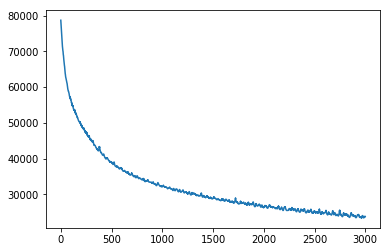

In [20]:
train_model(3000, model)
costs = model['costs']
plt.plot(costs[-3000:])
#print(W[1])

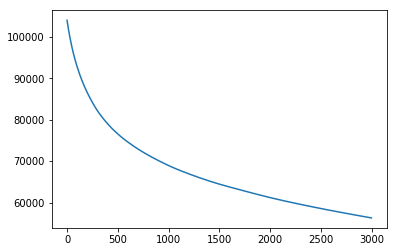

In [33]:
plt.plot(costs[-3000:])

## Section 3, Inspect Performance

In [18]:
def get_accuracy(pred, real):
    right = np.sum(pred==real)
    acc = right/real.shape[1]
    return acc

In [21]:
predict = model['predict']
pred = predict(model, train_X)
pred = Y_to_labels(pred)
acc = get_accuracy(pred, train_labels)
print("training set accuracy: %f" % acc)
pred = predict(model, test_X)
pred = Y_to_labels(pred)
acc = get_accuracy(pred, test_labels)
print("test set accuracy: %f" % acc)

training set accuracy: 0.895159
test set accuracy: 0.822143


In [78]:
np.savez("W-four-layer", *W)
np.savez("b-four-layer", *b)

In [79]:
test_X = np.genfromtxt("test.csv", delimiter=',', skip_header=1)
test_X = test_X.T
test_X = test_X/255
print(test_X.shape)

(784, 28000)


In [80]:
test_Y = predict(test_X)
test_labels = Y_to_labels(test_Y)
print(test_labels.shape)

(1, 28000)


In [81]:
output = np.zeros((test_labels.shape[1], 2), dtype=int)
for i in range(output.shape[0]):
    output[i, 0] = i+1
    output[i, 1] = test_labels[0, i]

In [82]:
np.savetxt("4layer-submission.csv", output, fmt="%d", delimiter=',', header='ImageId,Label')

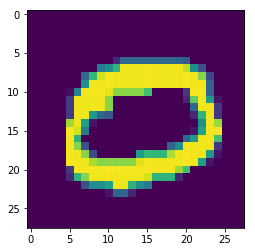

In [83]:
test_images = X_to_images(test_X)
plt.imshow(test_images[1])